# Floodscan Flood Exposure Observational Trigger

In [1]:
import pandas as pd
import geopandas as gpd
import ocha_stratus as stratus
import matplotlib.pyplot as plt
from src.datasources import codab
from src.utils import blob
from src.constants import *
from src.utils import rp_calc
from typing import List

In [2]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [54]:
PRIORITY = [BAMA, DIKWA, NGALA]

SAPPHIRE = "#007ce0"
TOMATO = "#f2645a"
TOMATO_DARK = "#c25048"
TOMATO_LIGHT = "#f7a29c"
MINT = "#1ebfb3"
GREY_DARK = "#888888"
GREY_LIGHT = "#cccccc"

In [4]:
engine = stratus.get_engine(stage="prod")

Get admin areas

<Axes: >

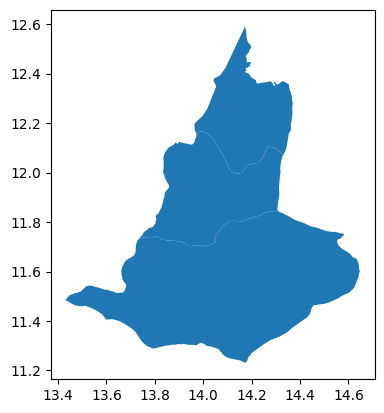

In [5]:
adm2 = codab.load_codab_from_blob(aoi_only=True, admin_level=2)
adm2_pri = adm2[adm2.ADM2_PCODE.isin(PRIORITY)]
adm2_pri.plot()

Get flood exposure data from the database

In [6]:
priority_values = "', '".join(PRIORITY)
priority_clause = f"('{priority_values}')"

query = f"SELECT * FROM app.floodscan_exposure WHERE iso3='NGA' and pcode IN {priority_clause}"
with engine.connect() as con:
    df_fe = pd.read_sql(query, con=con, parse_dates=["valid_date"])

Calculate return periods empirically

In [8]:
df_fe["year"] = df_fe.valid_date.dt.year
df_fe_peaks = (
    df_fe.groupby(["year", "pcode"])
    .agg(
        fe_max=("sum", "max"),
        fe_max_date=(
            "sum",
            lambda x: df_fe.loc[x.idxmax(), "valid_date"],
        ),
    )
    .reset_index()
)

rp_vals = {}
rps = [3, 3.5, 4, 4.5, 5]

for rp in rps:
    rp_vals[rp] = {}
    for pcode in df_fe_peaks.pcode.unique():
        dff = df_fe_peaks[df_fe_peaks.pcode == pcode]
        rp_val = dff["fe_max"].quantile(1 - 1 / rp)
        rp_vals[rp][pcode] = rp_val

Display exceedance on a plot for each pcode

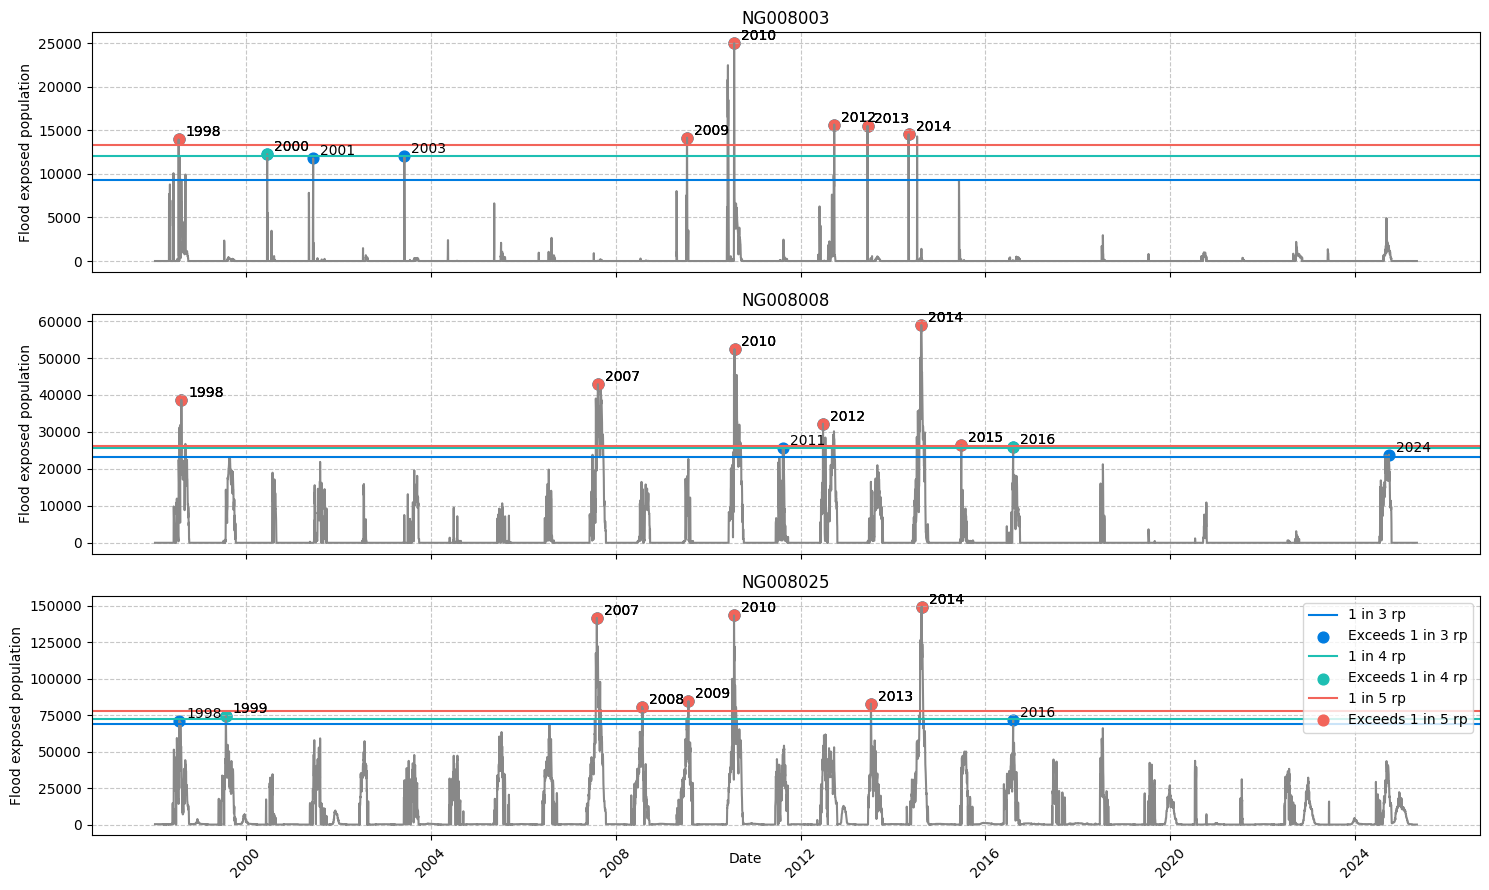

In [74]:
pcodes = df_fe["pcode"].unique()
n_pcodes = len(pcodes)

n_cols = 1
n_rows = n_pcodes

rp_display = {3: SAPPHIRE, 4: MINT, 5: TOMATO}

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows), sharex=True)
axes = axes.flatten()

for i, pcode in enumerate(pcodes):
    dff = df_fe[df_fe["pcode"] == pcode].sort_values("valid_date")
    dff_fe_peaks = df_fe_peaks[df_fe_peaks["pcode"] == pcode]
    axes[i].plot(dff["valid_date"], dff["sum"], c=GREY_DARK)
    axes[i].set_title(pcode)
    axes[i].set_ylabel("Flood exposed population")
    axes[i].tick_params(axis="x", rotation=45)
    axes[i].grid(True, linestyle="--", alpha=0.7)

    mask_rp3 = df_fe_peaks["fe_max"] >= rp_vals[3][pcode]
    mask_rp4 = df_fe_peaks["fe_max"] >= rp_vals[4][pcode]
    mask_rp5 = df_fe_peaks["fe_max"] >= rp_vals[5][pcode]

    for rp, c in rp_display.items():
        axes[i].axhline(rp_vals[rp][pcode], c=c, label=f"1 in {rp} rp")
        mask = dff_fe_peaks["fe_max"] >= rp_vals[rp][pcode]
        axes[i].scatter(
            dff_fe_peaks.loc[mask, "fe_max_date"],
            dff_fe_peaks.loc[mask, "fe_max"],
            c=c,
            s=60,
            label=f"Exceeds 1 in {rp} rp",
        )

        for idx, row in dff_fe_peaks.loc[mask].iterrows():
            year = row["fe_max_date"].year
            axes[i].annotate(
                f"{year}",
                (row["fe_max_date"], row["fe_max"]),
                xytext=(5, 0),  # Offset text slightly above and to the right
                textcoords="offset points",
                ha="left",
                va="bottom",
                color="black",
                fontsize=10,
            )


fig.text(0.5, 0.04, "Date", ha="center", va="center")
plt.legend()
plt.tight_layout()
plt.savefig("fe_exceedance.png", dpi=300)
plt.show()

Now look at combined RPs

In [19]:
df_combined = rp_calc.calculate_groups_rp(
    df_fe_peaks, by=["pcode"], col_name="fe_max", ascending=False
)

In [71]:
df_combined

,pcode,year,fe_max,fe_max_date,fe_max_rank,fe_max_rp
0,NG008003,1998,13960.0,1998-07-18,6.0,4.833333
1,NG008003,1999,2348.0,1999-07-13,17.0,1.705882
2,NG008003,2000,12284.0,2000-06-17,7.0,4.142857
3,NG008003,2001,11783.0,2001-06-15,9.0,3.222222
4,NG008003,2002,1478.0,2002-07-14,19.0,1.526316
...,...,...,...,...,...,...
79,NG008025,2021,31071.0,2021-07-19,26.0,1.115385
80,NG008025,2022,38255.0,2022-07-28,24.0,1.208333
81,NG008025,2023,22756.0,2023-01-02,27.0,1.074074
82,NG008025,2024,43530.0,2024-09-05,22.0,1.318182


In [75]:
total_years = df_combined["year"].nunique()

dicts = []
for rp in df_combined["fe_max_rp"].unique():
    dff = df_combined[df_combined["fe_max_rp"] >= rp]
    dicts.append(
        {
            "rp_ind": rp,
            "rp_combined": (
                (total_years + 1) / dff["year"].nunique()
                if dff["year"].nunique() > 0
                else np.inf
            ),
        }
    )

df_rps = pd.DataFrame(dicts)

In [87]:
df_rps[df_rps.rp_ind > 2].sort_values("rp_ind")

,rp_ind,rp_combined
8,2.071429,1.526316
20,2.230769,1.526316
26,2.416667,1.526316
7,2.636364,1.526316
17,2.900000,1.705882
3,3.222222,1.812500
5,3.625000,2.071429
2,4.142857,2.416667
0,4.833333,3.222222
11,5.800000,4.142857


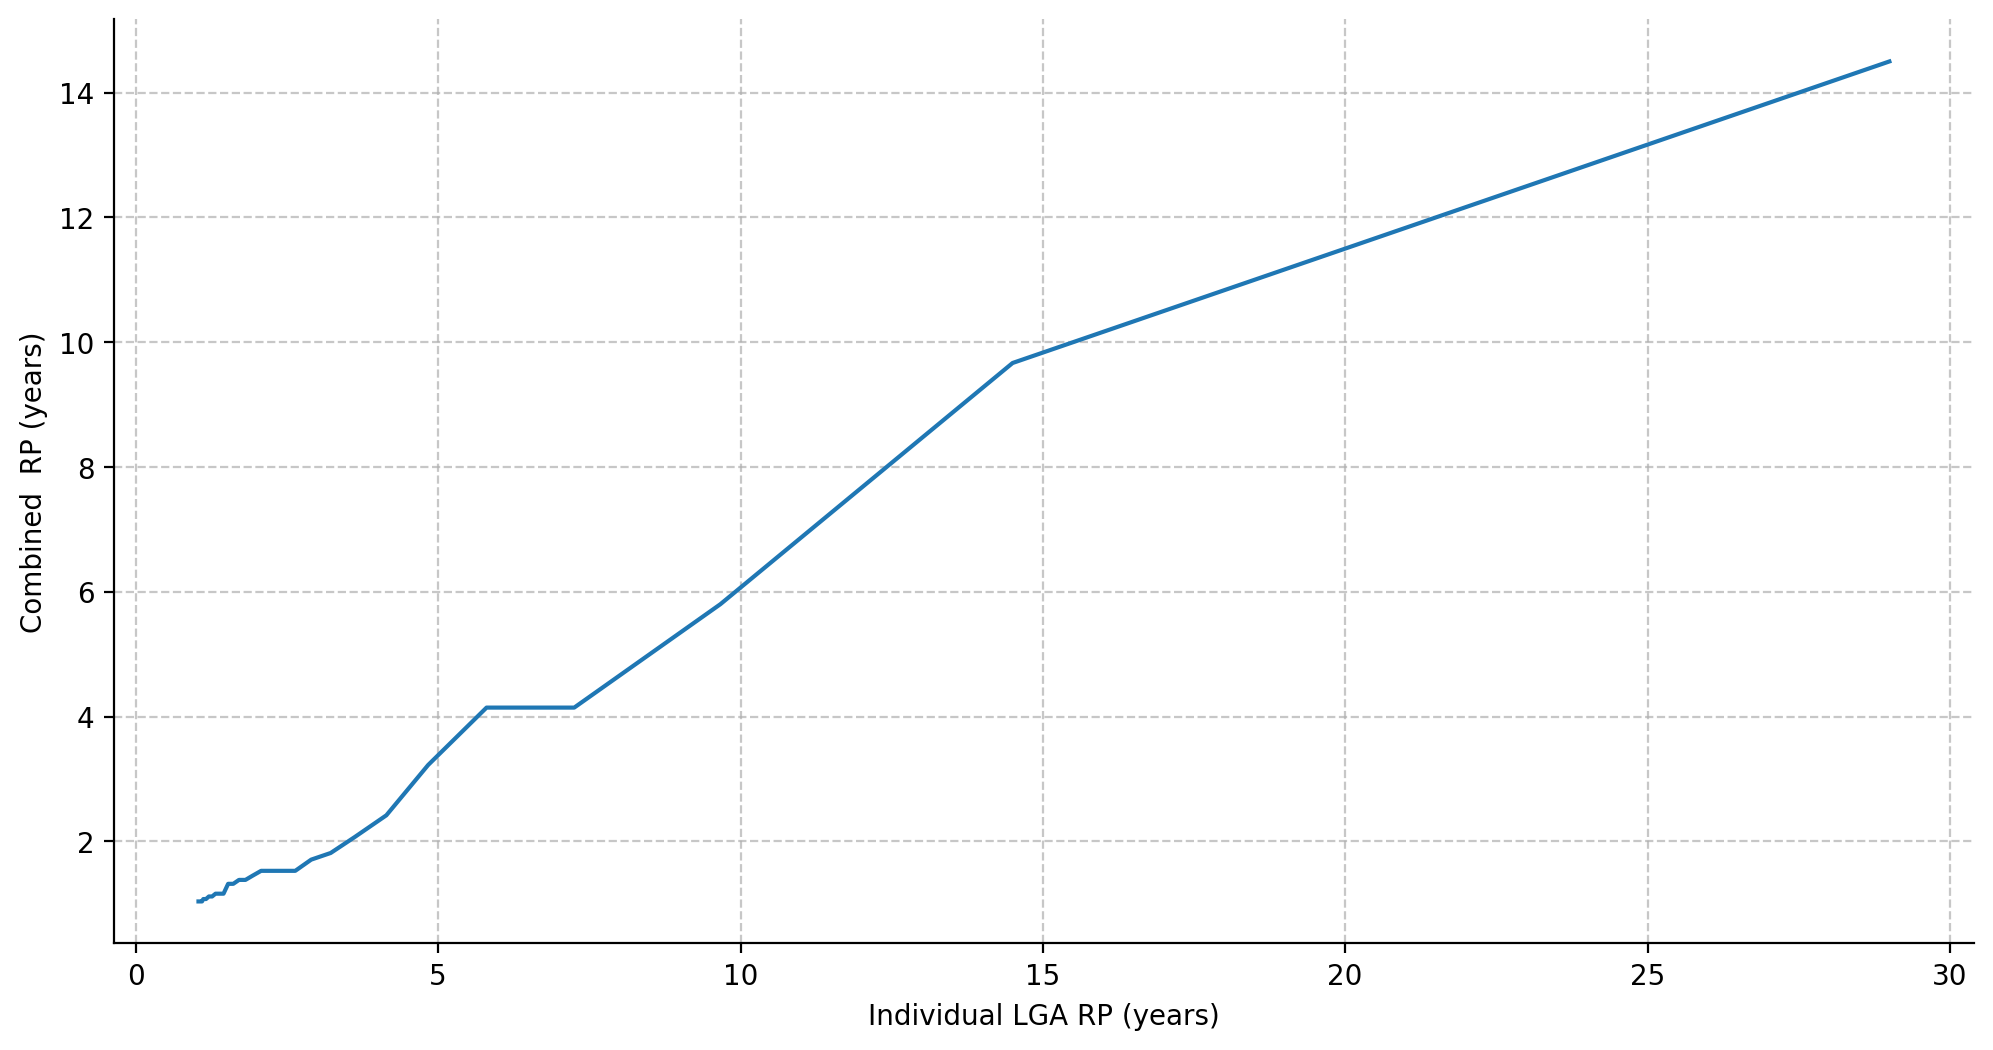

In [84]:
fig, ax = plt.subplots(dpi=200, figsize=(12, 6))

df_rps.sort_values("rp_ind").plot(
    x="rp_ind", y="rp_combined", legend=False, ax=ax
)

ax.set_xlabel("Individual LGA RP (years)")
ax.set_ylabel("Combined  RP (years)")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(True, linestyle="--", alpha=0.7)
plt.savefig("combined_rp.png", dpi=300)